In [1]:
import os
import pathlib
import datetime
import time

import tensorflow as tf

import matplotlib.pyplot as plt
from IPython import display

In [2]:
dataset_name = "facades"
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/" + dataset_name + ".tar.gz"
path_to_tar = tf.keras.utils.get_file(
    fname=dataset_name + ".tar.gz",
    origin=dataset_url,
    extract=True
)
path_to_tar = pathlib.Path(path_to_tar)
dataset_path = path_to_tar.parent/dataset_name

In [3]:
BUFFERSIZE = 400
BATCHSIZE = 1
WIDTH = 256
HEIGHT = 256
LAMBDA = 100

In [4]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    w = tf.shape(image)[1] // 2    
    input_image = image[:, w:, :]
    input_image = tf.cast(input_image, tf.float32)
    real_image = image[:, :w, :]
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, HEIGHT, WIDTH, 3])
    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [5]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, HEIGHT, WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

train_dataset = tf.data.Dataset.list_files(str(dataset_path / "train/*.jpg"))
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(BUFFERSIZE)
train_dataset = train_dataset.batch(BATCHSIZE)

test_dataset = tf.data.Dataset.list_files(str(dataset_path / "test/*.jpg"))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCHSIZE)

In [11]:
def downsample(filters, size, apply_batchnorm=True):
    init = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    init = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=init, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=init)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

generator = Generator()
discriminator = Discriminator()

In [12]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_generator_loss = gan_loss + (LAMBDA * l1_loss)
    return total_generator_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [15]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    ims = [test_input[0], tar[0], prediction[0]]
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(ims[i] * 0.5 + 0.5)
    plt.show()

@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    gen_grads = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if step%1000 == 0:
            display.clear_output(wait=True)
            generate_images(generator, example_input, example_target)
        train_step(input_image, target, step)

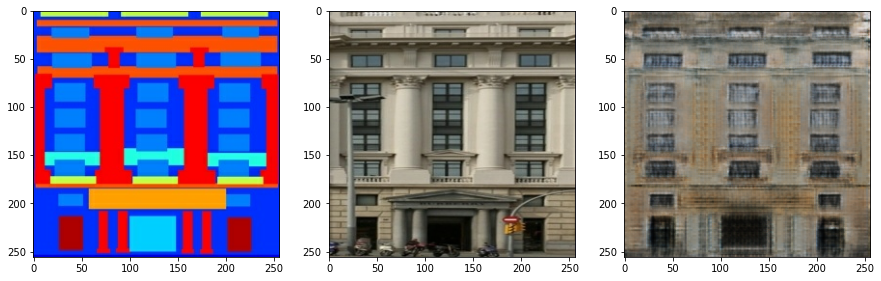

In [17]:
fit(train_dataset, test_dataset, steps=10000)